<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# PCA Lab: Speed Dating

_Authors: Kiefer Katovich (SF)_

---

Let's practice principal component analysis (PCA) using a data set from Kaggle. PCA is often used to simplify data, reduce noise, and find unmeasured latent variables, so it's important to take the time to understand what's going on.

**In this lab, we will:**

- Explore how PCA relates to correlation.
- Use PCA to perform dimensionality reduction.
- Predict whether or not a speed dater likes reading based on the dater's other likes.

---

### Data Set

The data set we're using for this lab is a subset of this [much more detailed speed dating data set](https://www.kaggle.com/annavictoria/speed-dating-experiment). In particular, this contains no information on the actual speed dating itself (i.e., successes with or opinions of other individuals). 

It also contains no follow-up information where individuals are asked the same questions about themselves again. It only contains information about what an individual enjoys doing, their self-ratings on how desirable they are, and how they think others rate them based on desirability.

The columns present in the data are outlined below:

FieldName|Description
---------|-----------
    subject_id                   |   Unique individual identifier.
    wave                         |   Meetup ID.
    like_sports                  |   Enjoyment of participating in sports.
    like_tvsports                |   Enjoyment of watching sports on TV.
    like_exercise                |   Enjoyment of exercise.
    like_food                    |   Enjoyment of food.
    like_museums                 |   Enjoyment of museums.
    like_art                     |   Enjoyment of art.
    like_hiking                  |   Enjoyment of hiking.
    like_gaming                  |   Enjoyment of playing games.
    like_clubbing                |   Enjoyment of going clubbing/partying.
    like_reading                 |   Enjoyment of reading.
    like_tv                      |   Enjoyment of TV in general.
    like_theater                 |   Enjoyment of the theater (plays, musicals, etc.).
    like_movies                  |   Enjoyment of movies.
    like_concerts                |   Enjoyment of concerts.
    like_music                   |   Enjoyment of music.
    like_shopping                |   Enjoyment of shopping.
    like_yoga                    |   Enjoyment of yoga.
    subjective_attractiveness    |   How attractive they rate themselves.
    subjective_sincerity         |   How sincere they rate themselves.
    subjective_intelligence      |   How intelligent they rate themselves.
    subjective_fun               |   How fun they rate themselves.
    subjective_ambition          |   How ambitious they rate themselves.
    objective_attractiveness     |   Perceived rating others would give them on how attractive they are.
    objective_sincerity          |   Perceived rating others would give them on how sincere they are.
    objective_intelligence       |   Perceived rating others would give them on how intelligent they are.
    objective_fun                |   Perceived rating others would give them on how fun they are.
    objective_ambition           |   Perceived rating others would give them on how ambitious they are.
    
There are 551 subjects total.

---

### 1) Load packages.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

%config InlineBackend.figure_format = 'retina'

---

### 2) Load and clean the speed dating data.

- First, remove columns with more than 200 missing values.
- Then, remove rows with missing values.
- Verify that no rows contain NaNs.

In [6]:
sd = pd.read_csv('./datasets/speed_dating.csv')

In [7]:
sd.shape

(551, 29)

In [8]:
sd.columns

Index(['subject_id', 'wave', 'like_sports', 'like_tvsports', 'like_exercise',
       'like_food', 'like_museums', 'like_art', 'like_hiking', 'like_gaming',
       'like_clubbing', 'like_reading', 'like_tv', 'like_theater',
       'like_movies', 'like_concerts', 'like_music', 'like_shopping',
       'like_yoga', 'subjective_attractiveness', 'subjective_sincerity',
       'subjective_intelligence', 'subjective_fun', 'subjective_ambition',
       'objective_attractiveness', 'objective_sincerity',
       'objective_intelligence', 'objective_fun', 'objective_ambition'],
      dtype='object')

In [9]:
sd.isnull().sum()

subject_id                     0
wave                           0
like_sports                    7
like_tvsports                  7
like_exercise                  7
like_food                      7
like_museums                   7
like_art                       7
like_hiking                    7
like_gaming                    7
like_clubbing                  7
like_reading                   7
like_tv                        7
like_theater                   7
like_movies                    7
like_concerts                  7
like_music                     7
like_shopping                  7
like_yoga                      7
subjective_attractiveness      9
subjective_sincerity           9
subjective_intelligence        9
subjective_fun                 9
subjective_ambition            9
objective_attractiveness     237
objective_sincerity          237
objective_intelligence       237
objective_fun                237
objective_ambition           237
dtype: int64

In [10]:
sd = sd.dropna(subset=['like_sports','subjective_attractiveness'])
sd = sd.drop(columns=['objective_attractiveness', 'objective_sincerity',
       'objective_intelligence', 'objective_fun', 'objective_ambition'])

In [11]:
sd.isnull().sum()

subject_id                   0
wave                         0
like_sports                  0
like_tvsports                0
like_exercise                0
like_food                    0
like_museums                 0
like_art                     0
like_hiking                  0
like_gaming                  0
like_clubbing                0
like_reading                 0
like_tv                      0
like_theater                 0
like_movies                  0
like_concerts                0
like_music                   0
like_shopping                0
like_yoga                    0
subjective_attractiveness    0
subjective_sincerity         0
subjective_intelligence      0
subjective_fun               0
subjective_ambition          0
dtype: int64

In [12]:
sd['like_reading'].value_counts()

like_reading
9.0     127
8.0     104
10.0     90
7.0      83
6.0      54
5.0      40
4.0      15
3.0      15
2.0      10
13.0      3
1.0       1
Name: count, dtype: int64

---

### 3) Example: Are the `subjective` columns correlated?

Here, we'll understand how the `subjective` columns are correlated.

- Find the z scores of each `subjective` column (i.e. standardize the `subjective` columns).
- Visualize correlation using [PairGrid](https://seaborn.pydata.org/generated/seaborn.PairGrid.html).
- Visualize correlation using a heat map.

**3.A) Find the z scores of each column. This allows the columns to more easily be directly compared.**

In [15]:
sub_cols = [col for col in sd.columns if col.startswith('subjective')]

In [16]:
sub_cols

['subjective_attractiveness',
 'subjective_sincerity',
 'subjective_intelligence',
 'subjective_fun',
 'subjective_ambition']

In [17]:
# Standardize
sc = StandardScaler()

# Fit and transform the subjective columns to calculate z-scores
sub_sc = pd.DataFrame(sc.fit_transform(sd[sub_cols]), 
                          columns=sub_cols)

# Display the Z_score
sub_sc.head()

,subjective_attractiveness,subjective_sincerity,subjective_intelligence,subjective_fun,subjective_ambition
0,-0.786472,-0.202716,-0.354194,0.193323,-0.323589
1,-0.066425,-2.329267,-0.354194,1.486916,-2.564932
2,0.653622,0.506135,0.564338,0.193323,0.236747
3,-0.066425,-0.202716,-1.272726,0.840119,0.236747
4,-0.786472,-3.746968,1.482870,-1.100270,0.236747


**3.B) Use a PairGrid to visualize correlation.**

[`PairGrid`](https://seaborn.pydata.org/generated/seaborn.PairGrid.html) is more general version of `pairplot`.  For example, you could use the following code, where `subjective` is a data frame containing only the subjective columns:

```python
g = sns.PairGrid(subjective)
# Regression plots in lower triangle
g = g.map_lower(sns.regplot) 
g = g.map_upper(sns.kdeplot, cmap="Blues", shade=True, shade_lowest=False)  # KDE plots in upper triangle
g = g.map_diag(plt.hist) # Histograms along diagonal

plt.show()
```

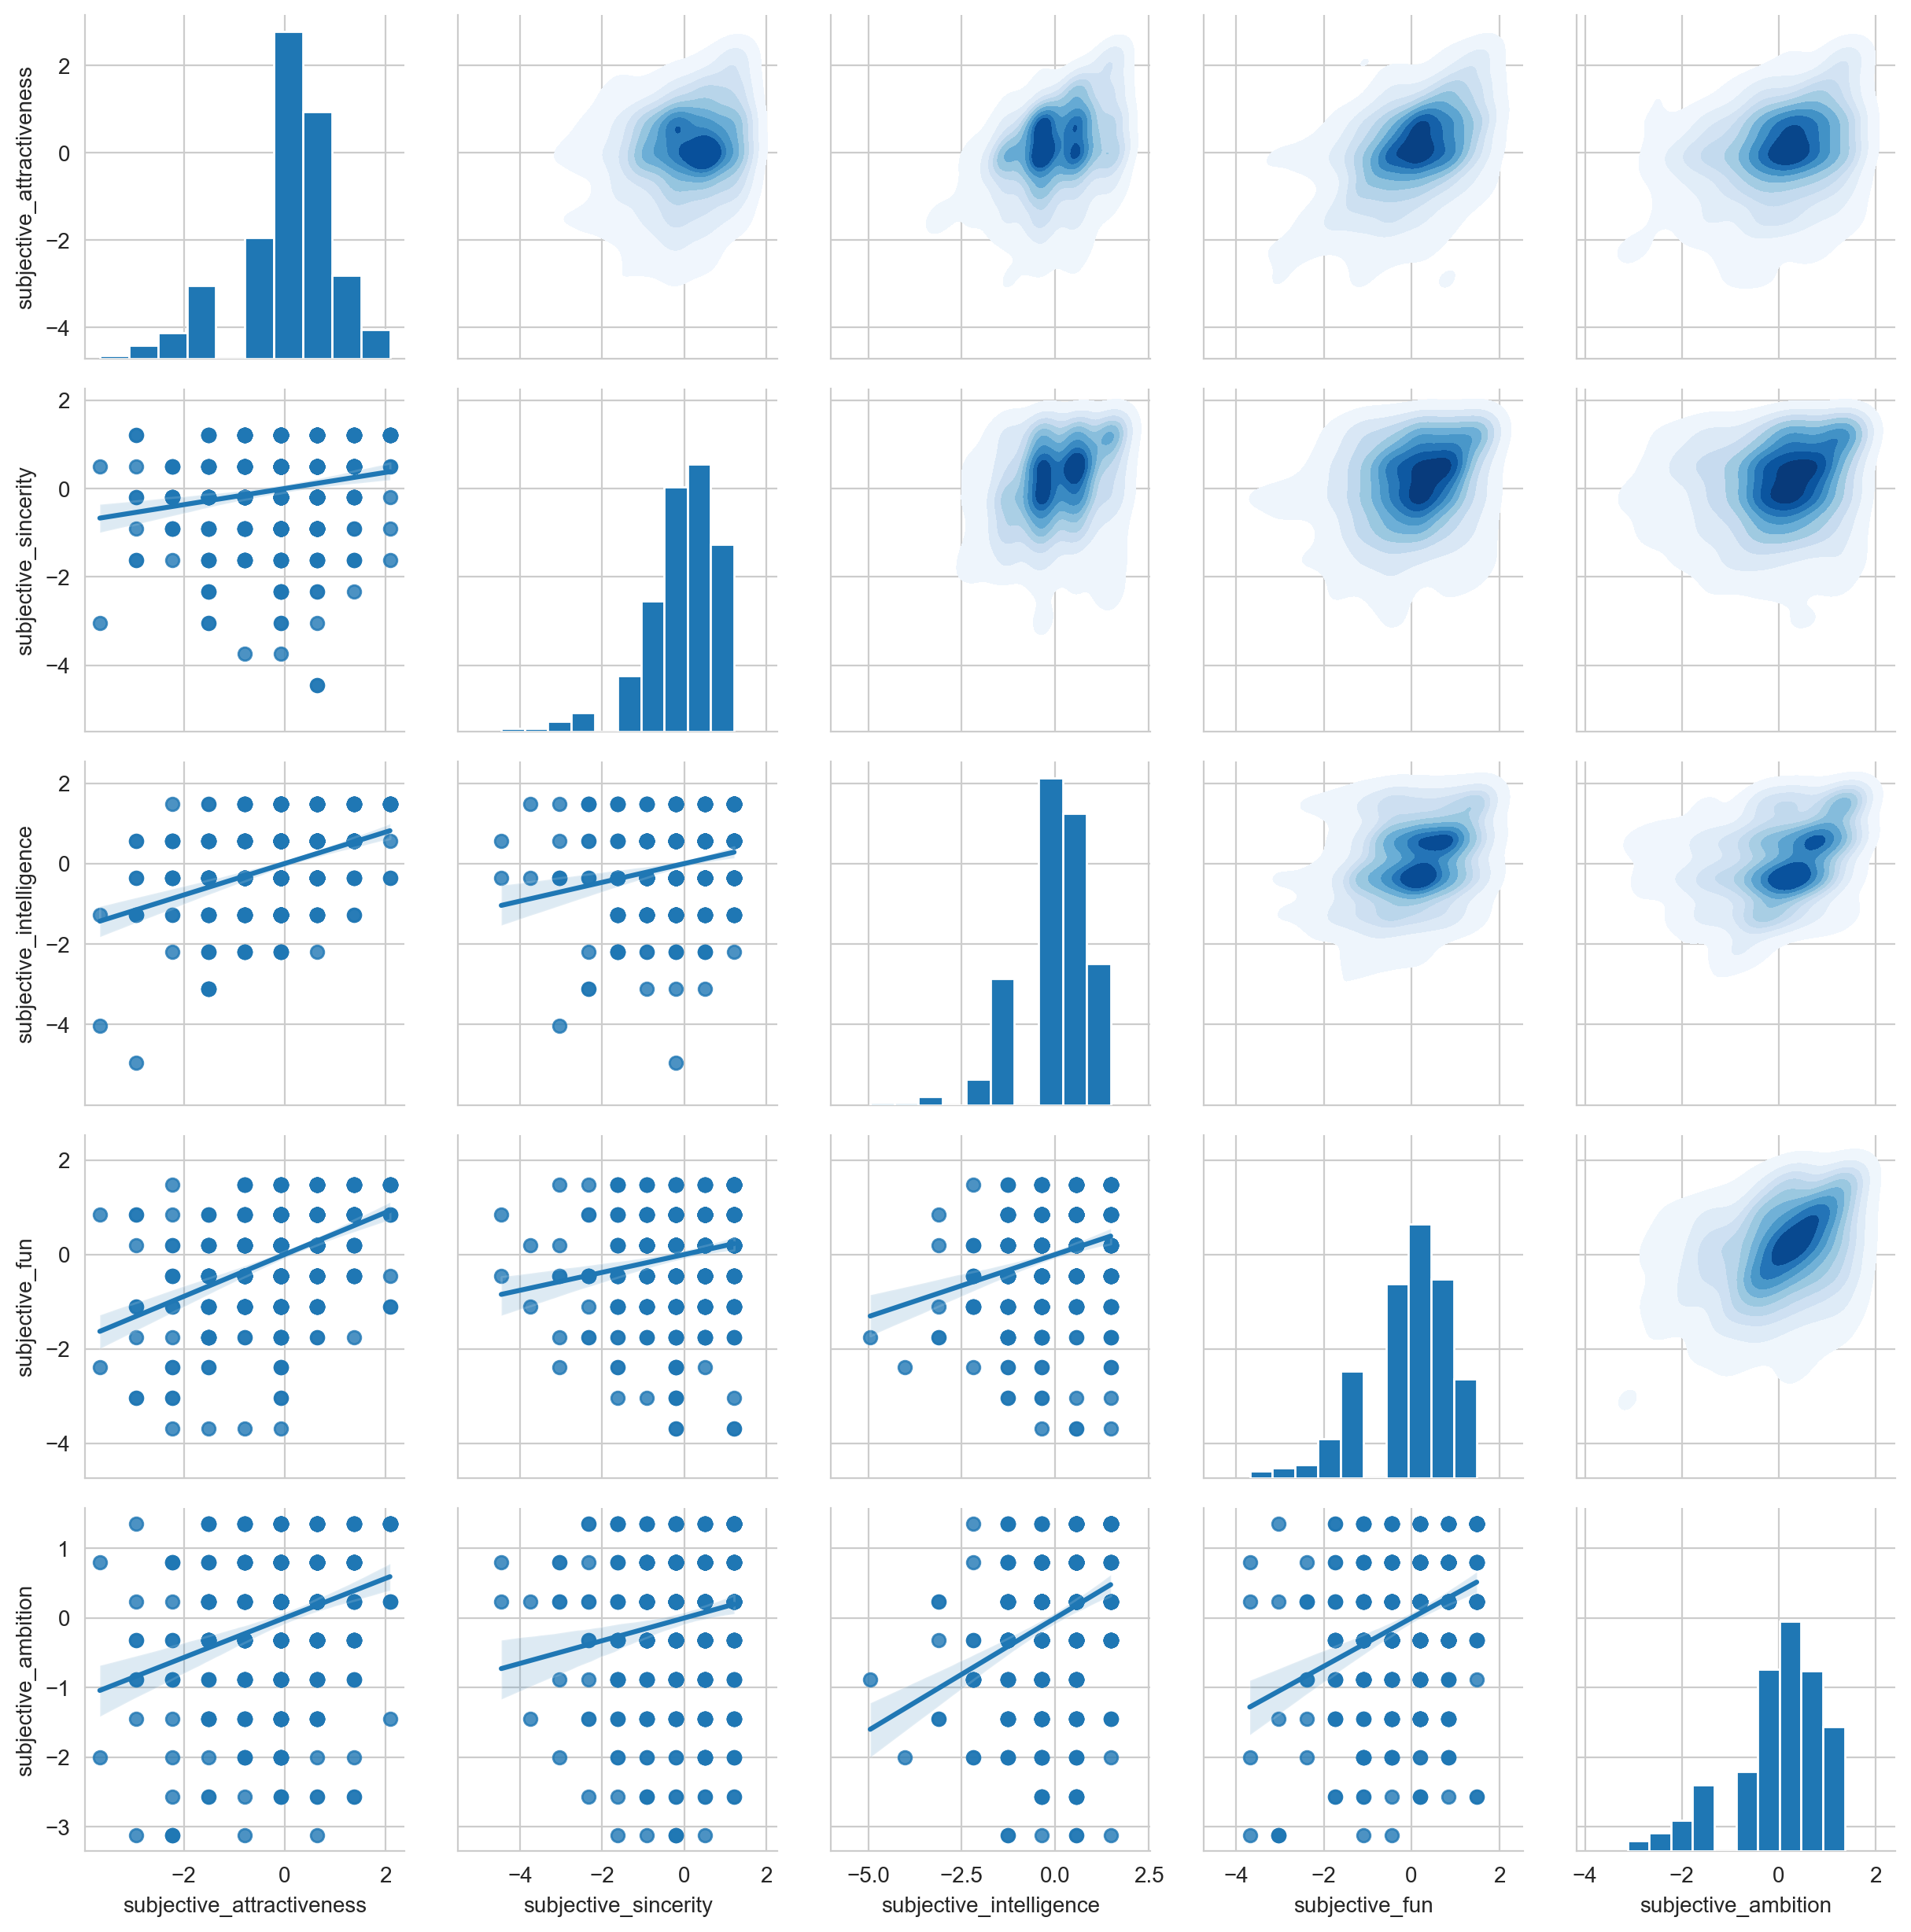

In [20]:
sub_pairgrid = sns.PairGrid(sub_sc)
# Regression plots in lower triangle
sub_pairgrid  = sub_pairgrid.map_lower(sns.regplot) 
sub_pairgrid  = sub_pairgrid.map_upper(sns.kdeplot, cmap="Blues",fill=True,thresh=0.05)  # KDE plots in upper triangle
sub_pairgrid  = sub_pairgrid.map_diag(plt.hist) # Histograms along diagonal

plt.show()

**3.C) Use a heat map to visualize correlation.**

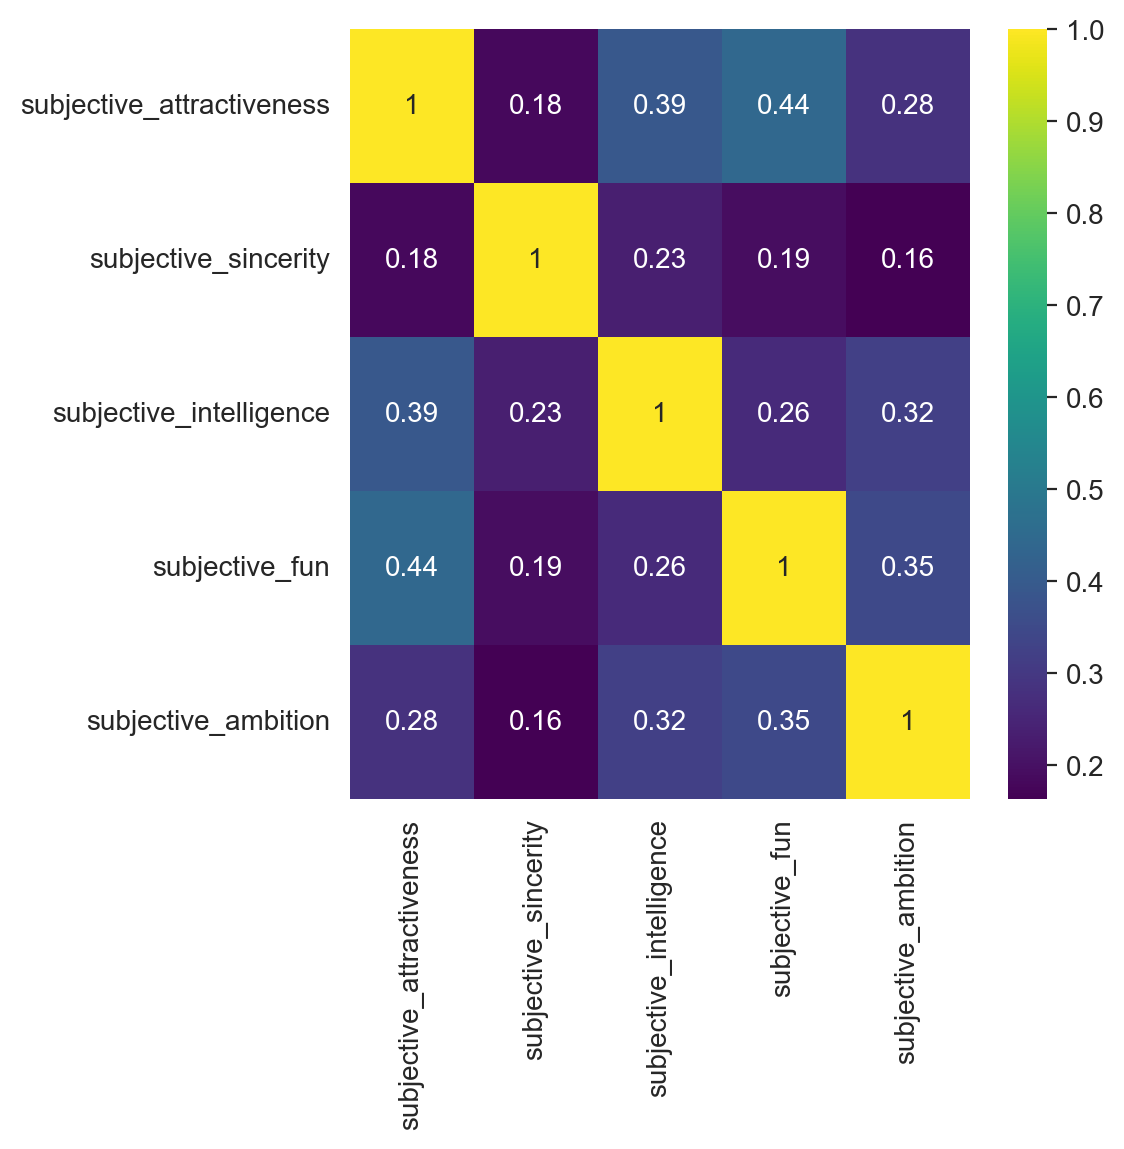

In [22]:
plt.figure(figsize=(5,5))
sns.heatmap(sub_sc.corr(), annot = True, cmap = 'viridis');
# From the heatmap below, it can be seen that all of them are insignificantly positive correlated to each others.

---

**Important: Did you ensure the results make sense intuitively?** If not, look at the results again. You should **always** interpret your results and ensure they make sense based on what you expected. If they don’t, investigate why — sometimes your analysis or data are wrong.

> For example, the results show that believing you are attractive and fun are correlated. Would you expect that believing you are intellectual and fun to have a higher or lower correlation? What do the results say?

---


### 4) Visualize some preference columns.

Next, we’ll explore how some preference ratings are correlated. You saw an example — now try it on the `preference_cols` below.

- Find the z scores of each column in `preference_cols`.
- Visualize correlation using PairGrid.
- Visualize correlation using a heat map.
- Do these results make sense intuitively? 

In [24]:
pre_cols = ['like_tvsports', 'like_sports', 'like_museums', 'like_theater', 'like_shopping']

**4.A) Find the z scores of each column in `preference_cols`.**

In [26]:
# Standardize
sc = StandardScaler()

# Fit and transform the subjective columns to calculate z-scores
pre_sc = pd.DataFrame(sc.fit_transform(sd[pre_cols]), columns=pre_cols)

# Display the Z_score
pre_sc.head()

,like_tvsports,like_sports,like_museums,like_theater,like_shopping
0,-0.912780,0.992539,-2.935051,-2.560869,0.913254
1,-0.912780,-1.291776,0.497620,0.985579,-1.000836
2,1.230441,-1.291776,-0.973525,0.098967,0.913254
3,-1.269983,-2.053215,-0.483143,0.985579,-1.766472
4,-0.198373,0.231101,-0.483143,-0.344339,0.913254


**4.B) Visualize correlation using PairGrid.**

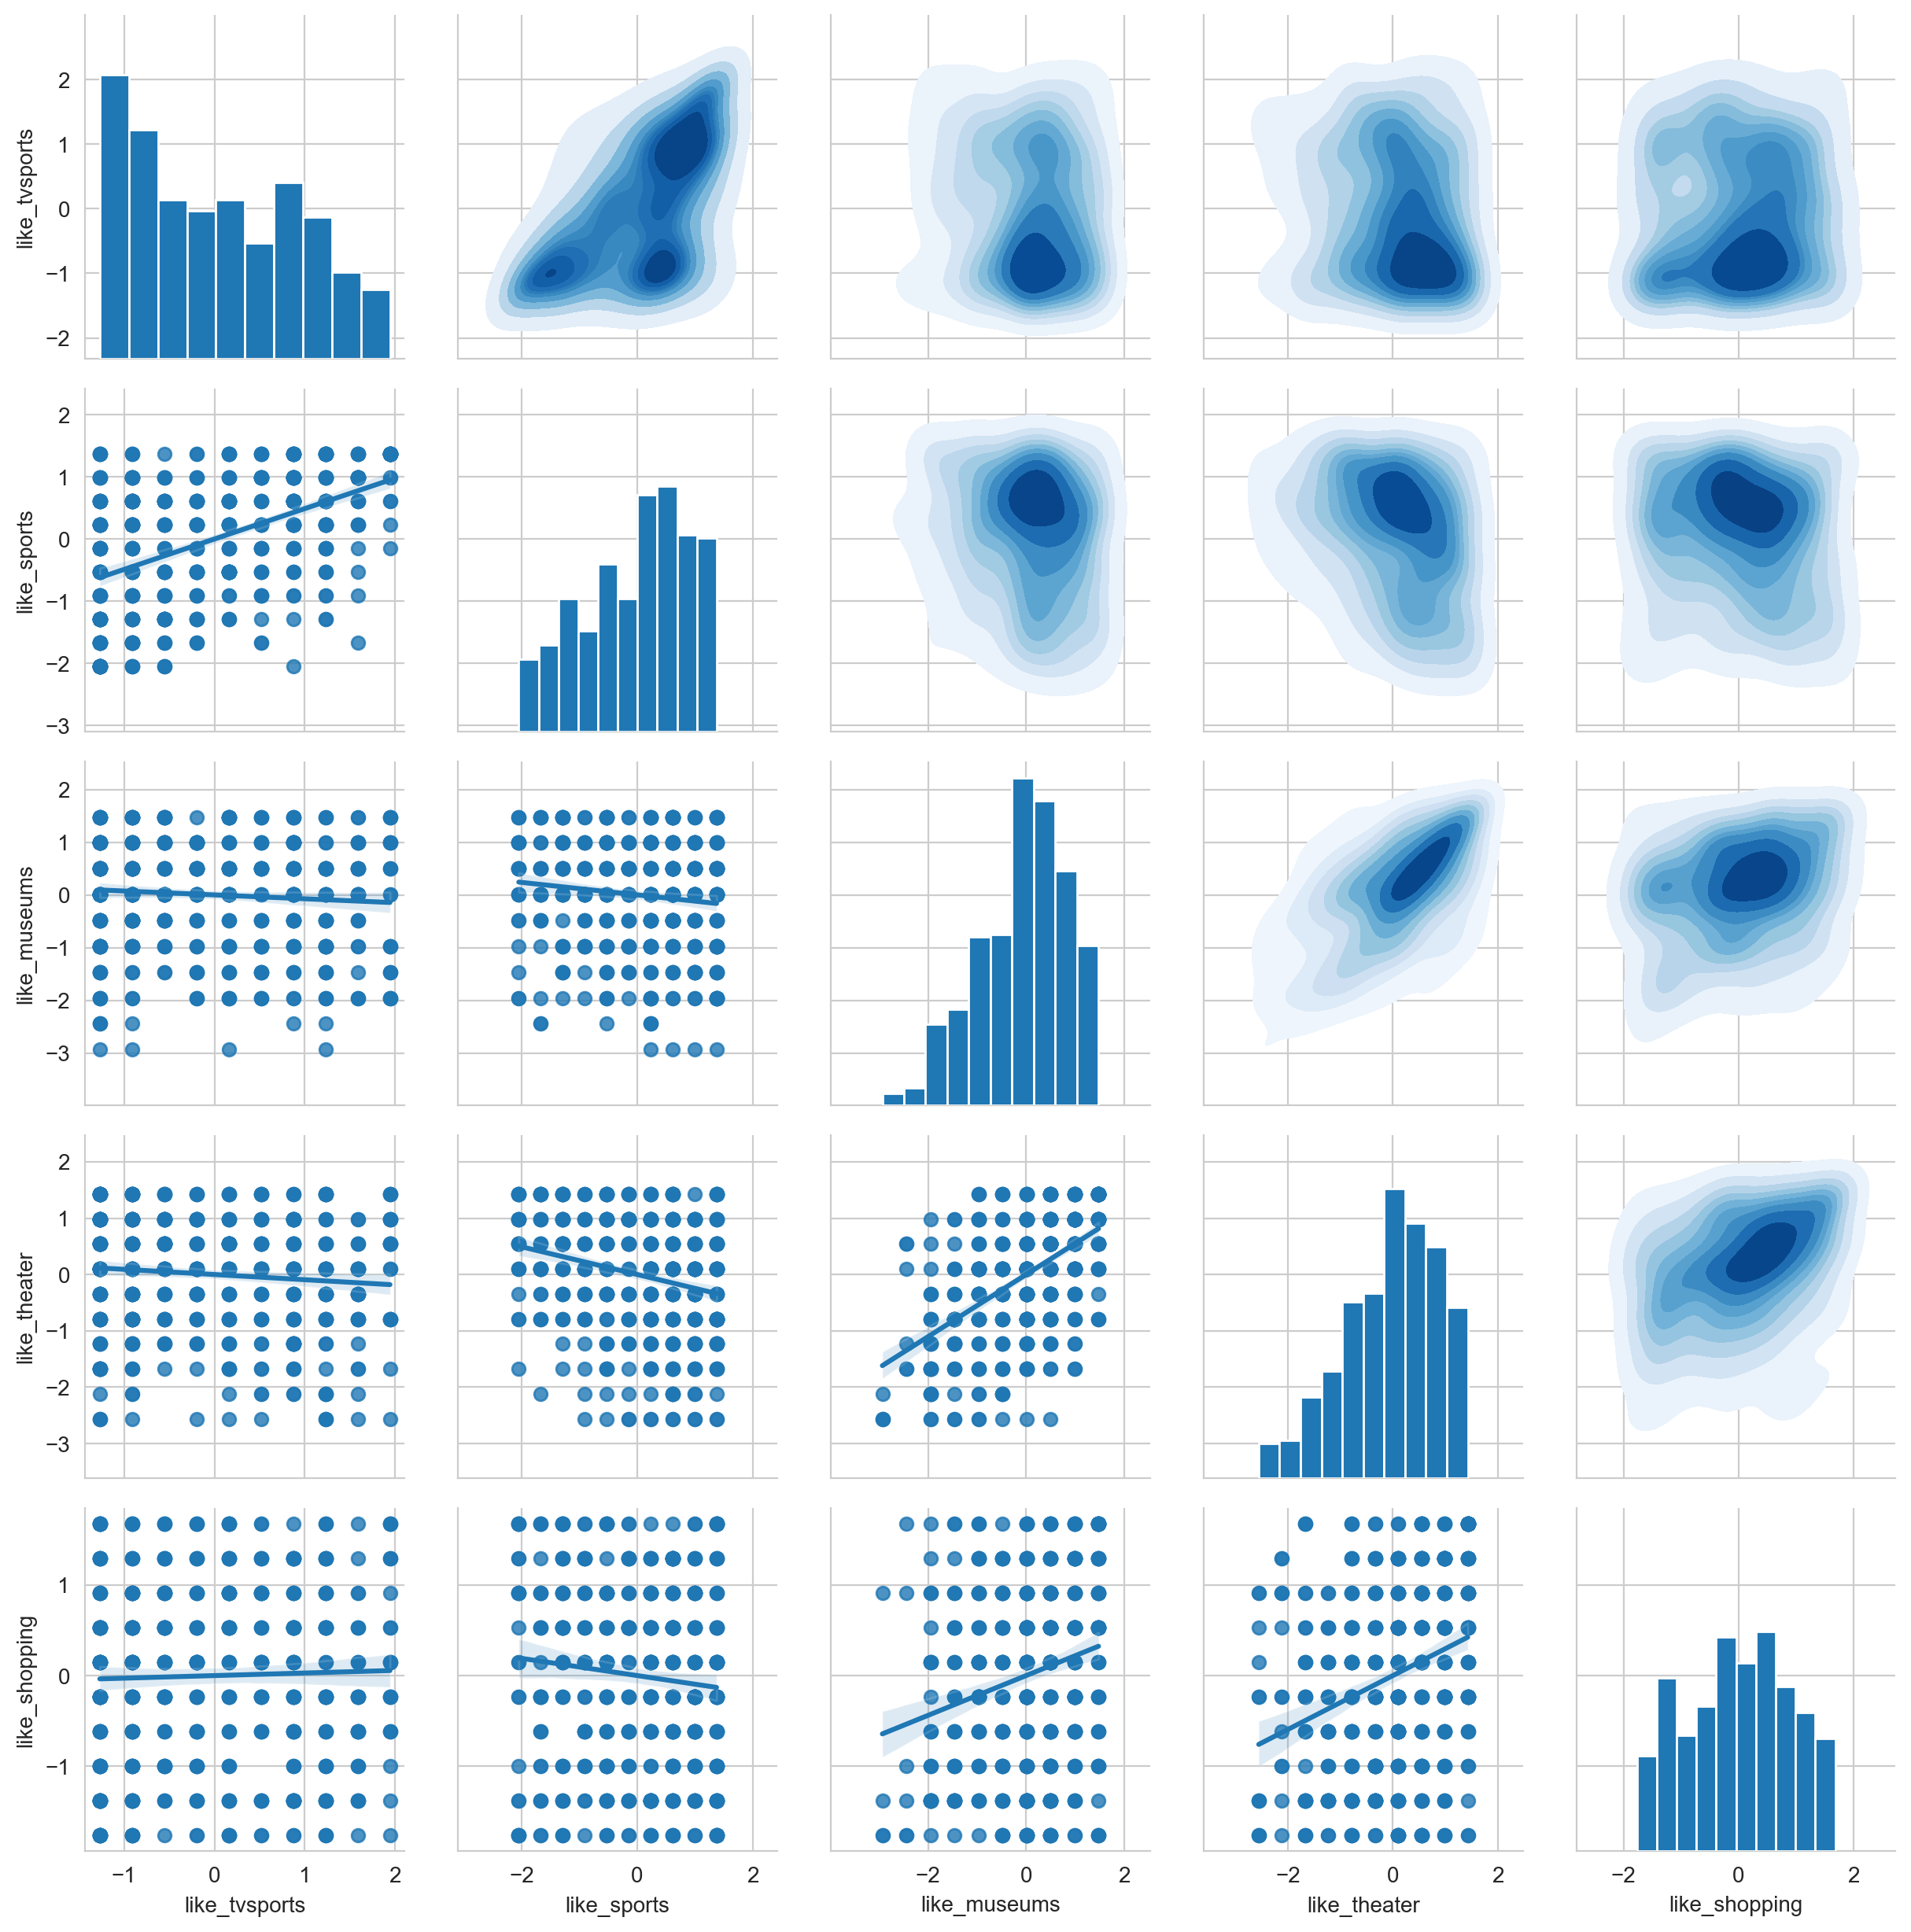

In [28]:
pre_pairgrid = sns.PairGrid(pre_sc)
# Regression plots in lower triangle
pre_pairgrid  = pre_pairgrid.map_lower(sns.regplot) 
pre_pairgrid  = pre_pairgrid.map_upper(sns.kdeplot, cmap="Blues",fill=True,thresh=0.05)  # KDE plots in upper triangle
pre_pairgrid  = pre_pairgrid.map_diag(plt.hist) # Histograms along diagonal

plt.show()

**4.C) Visualize correlation using a heat map.**

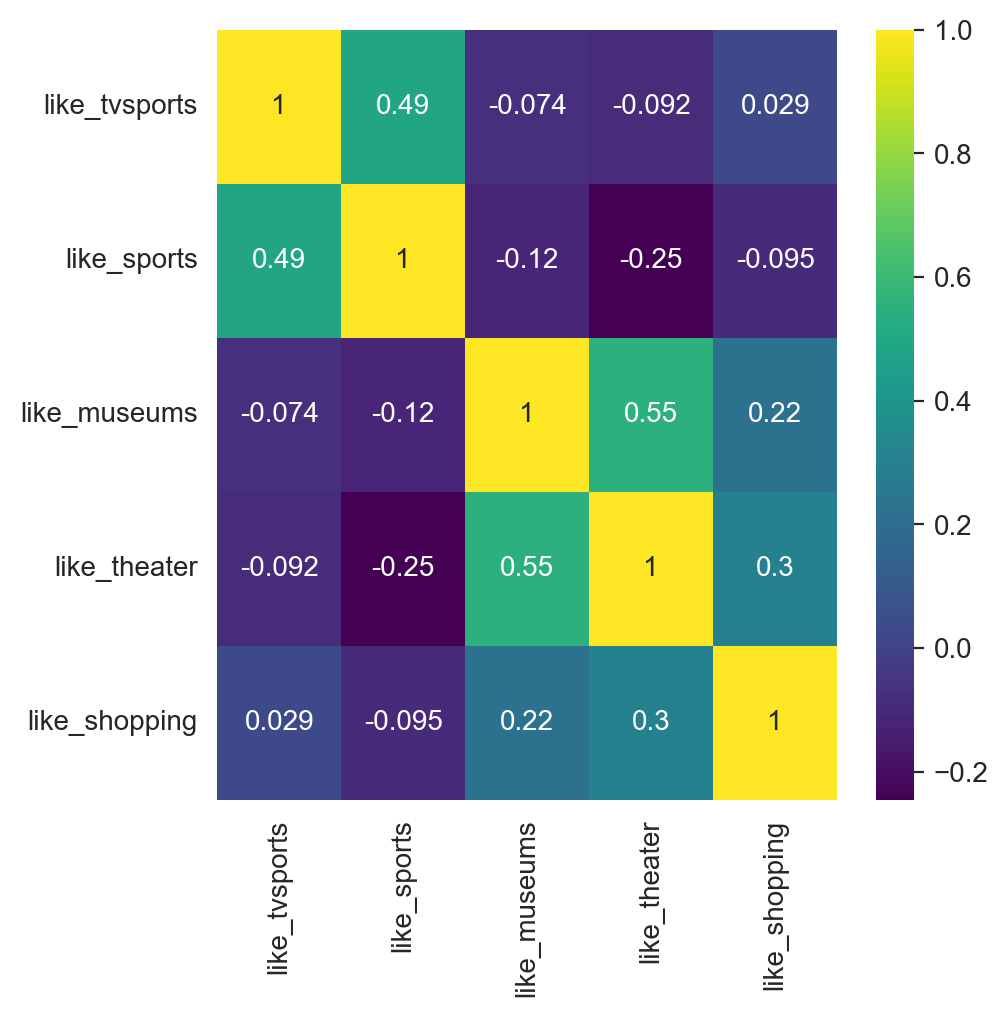

In [30]:
plt.figure(figsize=(5,5))
sns.heatmap(pre_sc.corr(), annot = True, cmap = 'viridis');
# From the heatmap below, it can be seen that most of them does not significantly correlated to each other; however,
# almost half of them are negative correlation.

---

### 5) Example: Fit PCA on the subjective ratings.

In [32]:
# Instantiate PCA with 5 components and random_state=42
sub_pca = PCA(n_components=5,random_state=42)

# Fit PCA to training data
sub_pca.fit(sd[sub_cols])

PCA(n_components=5, random_state=42)

---

**5.A) Look at the weights of the principal components.**

The principal components (or eigenvectors!) are simply the weights or coefficients on the original variables $X$ that transforms them to $Z$.

In [34]:
# Extract component weights (loadings) from a fitted PCA object
weights = sub_pca.components_

sub_weights = pd.DataFrame(
    data=weights.T,  # Transpose weights so features are rows
    columns=[f"PC{i+1}" for i in range(weights.shape[0])],  # Name columns PC1, PC2, etc.
    index=sub_cols)  

sub_weights

,PC1,PC2,PC3,PC4,PC5
subjective_attractiveness,-0.415953,0.375105,0.269136,-0.641854,0.449298
subjective_sincerity,-0.257067,0.417836,-0.849361,0.145340,0.129582
subjective_intelligence,-0.268777,0.088131,-0.077315,-0.410973,-0.863200
subjective_fun,-0.514436,0.371255,0.424832,0.630407,-0.140105
subjective_ambition,-0.651164,-0.734243,-0.140324,0.024226,0.128824


---

**5.B) Look at the explained variance values (aka eigenvalues) and the explained variance ratios.**

The eigenvalues are ordered such that the first components have the largest eigenvalues. The values and their normalized equivalent in the explained variance ratio attribute tell you how much of the variance in the original data is encapsulated in the new component variables.

In [36]:
# Extract the explained variance ratio for each principal component
# This shows how much of the total variance each component captures
var_exp = sub_pca.explained_variance_ratio_
print(f'Explained variance : {np.round(var_exp[:5], 4)}')
print('')

# Calculate cumulative explained variance
# Shows running total of variance explained as we add each component
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance : {np.round(cum_var_exp[:5], 4)}')

# This output helps us determine optimal number of components by showing:
# - Individual contribution: How much variance each component explains

Explained variance : [0.4505 0.1904 0.1658 0.1182 0.0752]

Cumulative explained variance : [0.4505 0.6409 0.8066 0.9248 1.    ]


---

**5.C) Transform the subjective data into the principal component space.**

The `transform()` function in the PCA will create your new component variable matrix.

In [58]:
# Transform PCA 
sub_pca = sub_pca.transform(sub_sc)
sub_pca

array([[16.81556928, -4.25846769,  3.68439955,  2.49069466,  2.93835878],
       [17.8567397 , -2.75098095,  6.5484759 ,  2.48064727,  2.51633377],
       [15.42258486, -3.75256923,  3.32026557,  1.30547105,  2.95655157],
       ...,
       [17.27790087, -4.6056348 ,  4.27649608,  1.89525191,  4.05351697],
       [18.90948077, -4.3661613 ,  2.6615467 , -0.03734648,  3.57060195],
       [17.31113027, -4.57566779,  4.19550641,  1.02534136,  4.46765199]])

This transformed our five-dimensional data set into vectors along its five principal components (with zero loss).
- Using these, we can now reduce the dimensionality of our data while minimizing loss.
- For example, taking only the first three eigenvectors accounts for `0.431 + 0.178 + 0.147 = 75.6%` of the variance.

---

**5.D) PCA-transformed features are not correlated.**

- Keep in mind that each column in the transformed data is no longer correlated.
- Compare this to the exploration above where many columns were correlated.

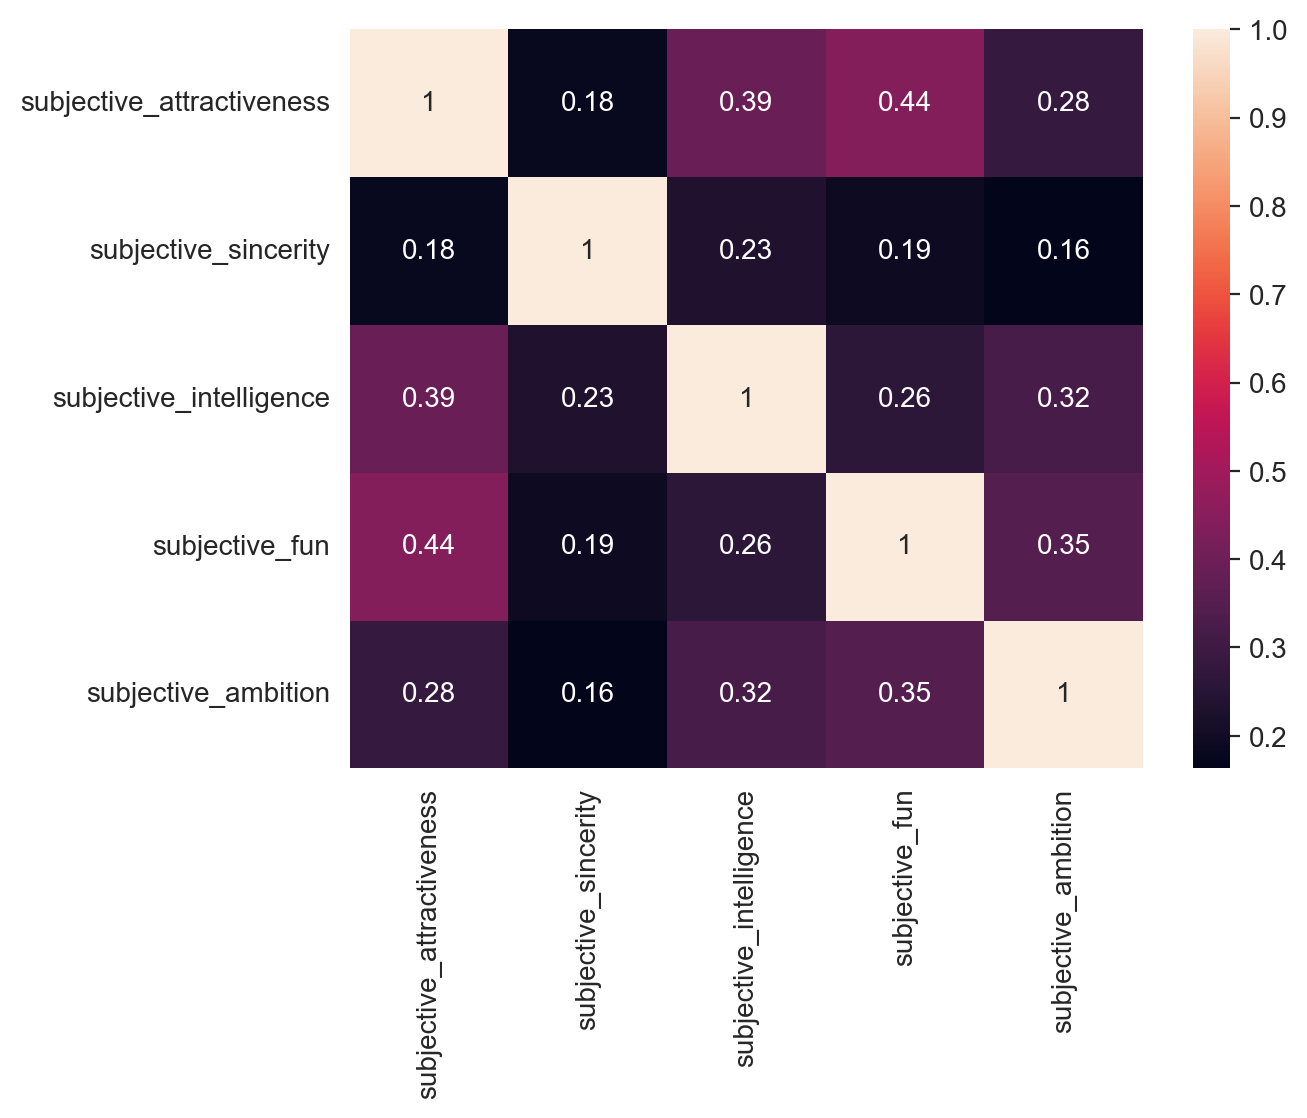

In [64]:
# Correlation before PCA transformation
sns.heatmap((sub_sc).corr(), annot=True)
plt.show()

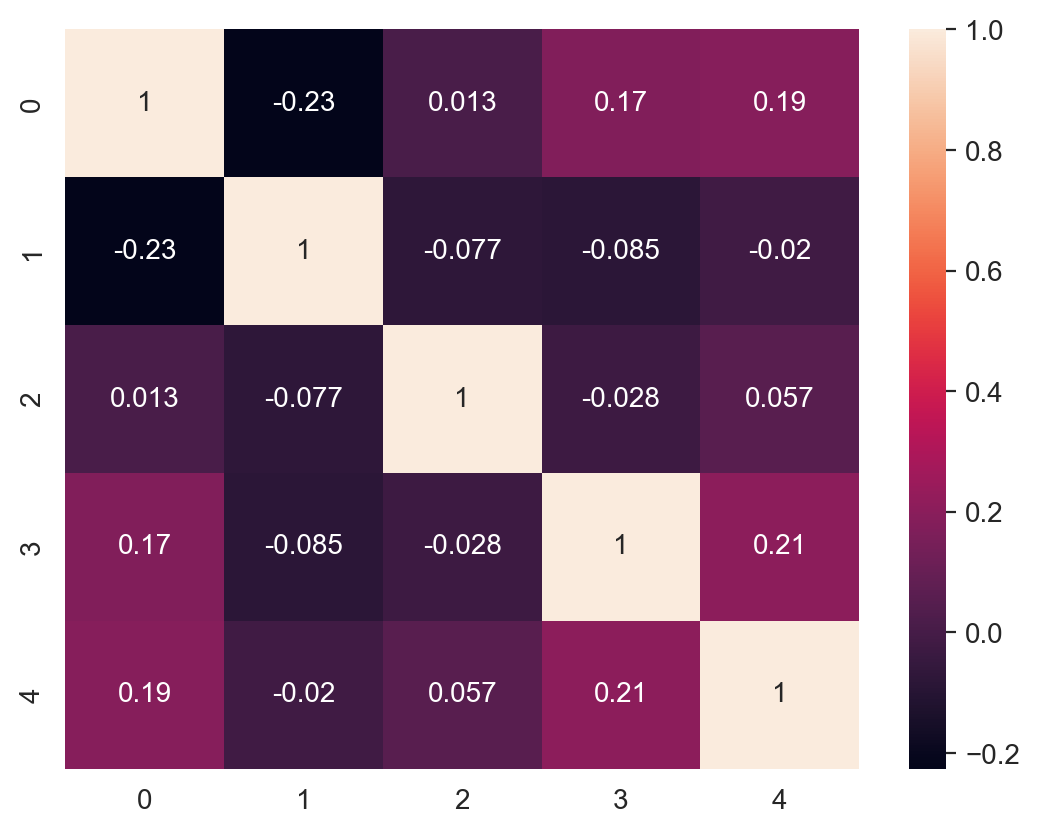

In [68]:
# Correlation after PCA transformation
sns.heatmap(pd.DataFrame(sub_pca).corr(), annot=True)
plt.show()

---

### 6) Optional: How were the data transformed?

To demonstrate how the new principal component matrix is created from the original variable columns and the eigenvector weighting matrix, we'll create the first component (PC1) manually.

**6.A) Pull out the eigenvector for PC1.**

In [19]:
# A:

**6.B) Create a DataFrame showing the original values for the subjective variables for `person1`.**

In [20]:
# A:

**6.C) Add the eigenvector for PC1: the weights by which to multiply each original variable.**

Recall that each component is a linear combination of the original variables, multiplied by a "weight" defined in the eigenvector of that component.

In [21]:
# A:

**6.D) Multiply the original variable values by the eigenvector values.**

These are the "pieces" of PC1 that will be added together to create the new value for that person.

In [22]:
# A:

**6.E) Sum the original values multiplied by the eigenvector weights to get `person1`’s value for PC1.**

In [23]:
# A:

---

### 7) Fit PCA on the preference data.

Now that you've seen how it's done, try it yourself!

- Find PCA eigenvalues and eigenvectors for the five `sd_like` columns.
- Transform the original `sd_like` columns into the principal component space.
- Verify that these columns are uncorrelated.

In [77]:
# Instantiate PCA with 5 components and random_state=42
pre_pca = PCA(n_components=5,random_state=42)

# Fit PCA to training data
pre_pca.fit(sd[pre_cols])

PCA(n_components=5, random_state=42)

#### 7.A) Find PCA eigenvalues and eigenvectors for the five `sd_like` columns.

In [79]:
# Extract component weights (loadings) from a fitted PCA object
weights = pre_pca.components_

pre_weights = pd.DataFrame(
    data=weights.T,  # Transpose weights so features are rows
    columns=[f"PC{i+1}" for i in range(weights.shape[0])],  # Name columns PC1, PC2, etc.
    index=pre_cols)  

pre_weights

,PC1,PC2,PC3,PC4,PC5
like_tvsports,0.627369,-0.446111,-0.110636,0.623387,0.080875
like_sports,0.621670,-0.171377,-0.085301,-0.742945,-0.157835
like_museums,-0.233043,-0.361941,-0.501806,-0.207093,0.721105
like_theater,-0.336857,-0.446306,-0.490124,0.019349,-0.668388
like_shopping,-0.228369,-0.664398,0.698894,-0.127118,0.042562


#### 7.B) Transform the original `sd_like` columns into the principal component space.

In [82]:
# Transform PCA 
pre_pca = pre_pca.transform(pre_sc)
pre_pca

array([[-0.25695293, 14.24632636,  7.33468965,  3.07481901, -0.70236457],
       [-3.23452965, 13.08429827,  2.73106403,  4.37299578, -0.31837552],
       [-1.68555619, 11.78463371,  5.00447216,  5.75324493, -0.53182397],
       ...,
       [-2.38639723, 12.60461183,  4.10986674,  3.9683748 , -0.12180297],
       [-2.38667476, 12.99942706,  4.85852851,  3.174351  ,  0.3692235 ],
       [-2.3307131 , 11.78141433,  3.58127879,  2.54381172,  0.74617995]])

#### 7.C) Verify that these columns are uncorrelated.

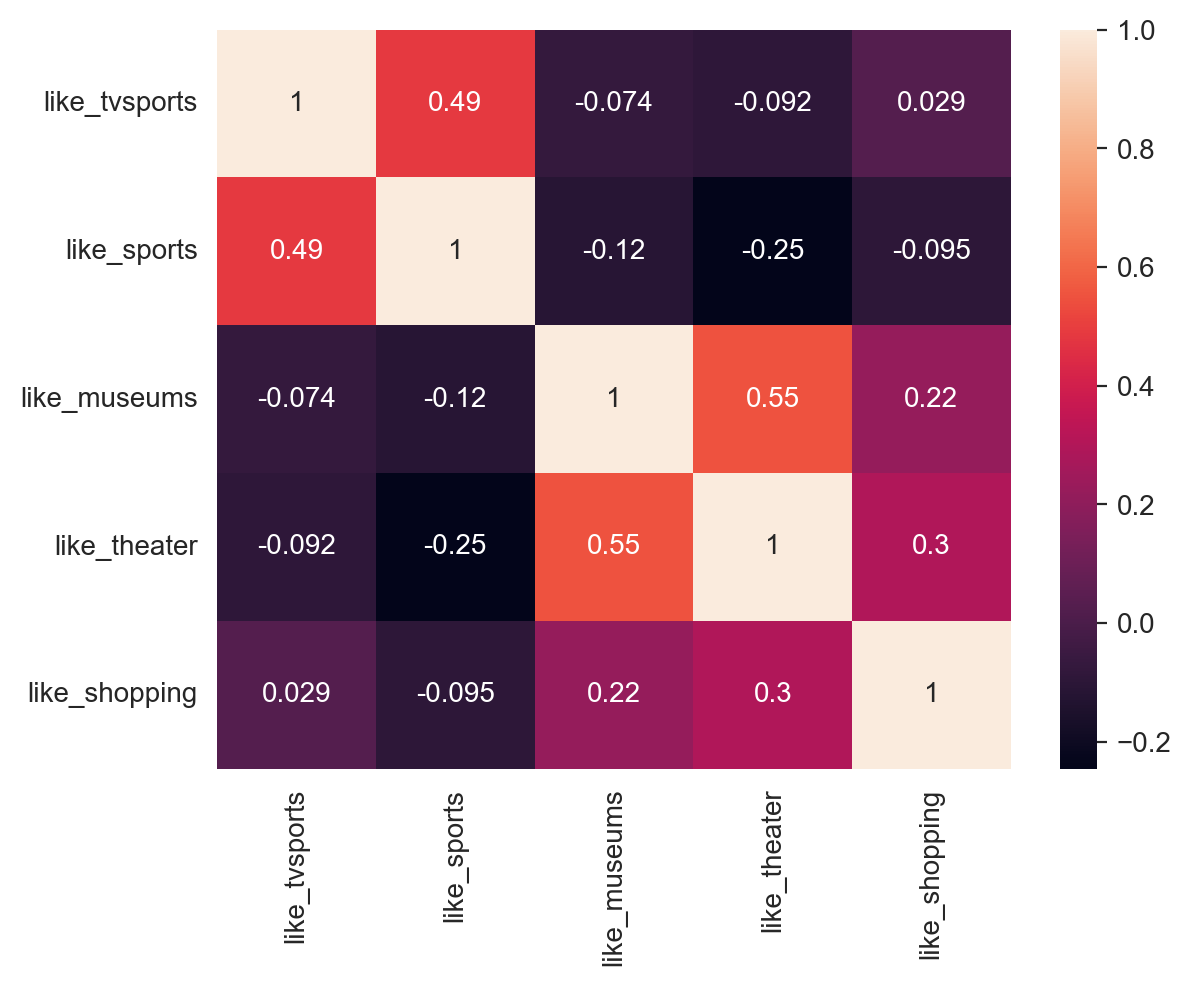

In [84]:
# Correlation before PCA transformation
sns.heatmap((pre_sc).corr(), annot=True)
plt.show()

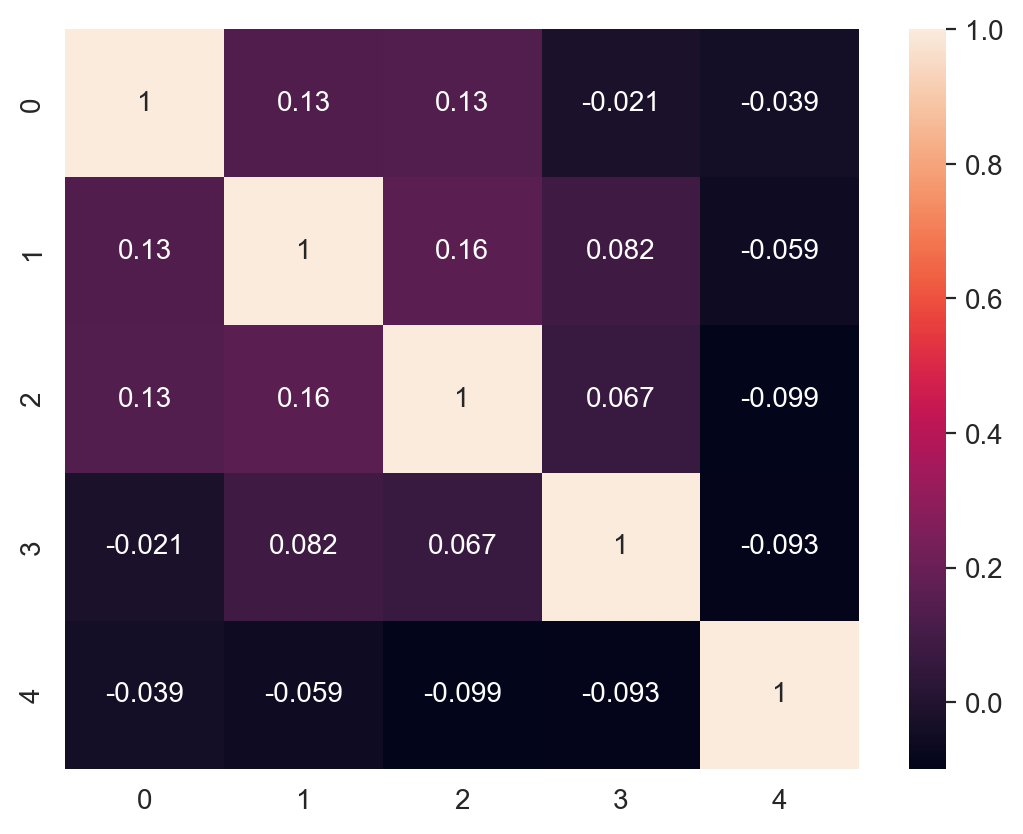

In [88]:
# Correlation after PCA transformation
sns.heatmap(pd.DataFrame(pre_pca).corr(), annot=True)
plt.show()

---

### 8) Use PCA for dimensionality reduction.

Using linear regression, let's predict whether or not a user likes reading.

**The key question:** Can we get the same prediction accuracy using only the first three principal components as features versus using all five original values as features?

In [90]:
reading = sd['like_reading'].values

**8.A) Linear regression cross-validated on original variables (`sd_like.values`).**

- What is the mean cross-validation score?
- Keep in mind that linear regression uses $R^2$ for score, so one is the ideal score.

In [92]:
# X,y
X = pre_sc
y = reading

# Standardize
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

# Create Linear Regression model
lm = LinearRegression()

In [94]:
# the mean cross-validation score
cv_scores = cross_val_score(lm, X_sc, y, cv=10, scoring='r2')
mean_cv_score = cv_scores.mean()
print(f'Mean cross-validation score: {mean_cv_score}')

Mean cross-validation score: 0.08752479304756662


**8.B) Linear regression on the first principal component.**

- What is the mean cross-validation score?

In [102]:
# the first principal component
pca_1 = PCA(n_components=1,random_state=42)
X_pca_1 = pca_1.fit_transform(X_sc)

# calculate CV
mean_cv_pca_1 = cross_val_score(lm, X_pca_1, y, cv=10, scoring='r2').mean()
print(f'Mean cross-validation score: {(mean_cv_pca_1).round(5)}')

Mean cross-validation score: 0.05087


**8.C) Linear regression on first three principal components.**

- What is the mean cross-validation score?

In [106]:
# the first three principal component
pca_2 = PCA(n_components=3,random_state=42)
X_pca_2 = pca_2.fit_transform(X_sc)

# calculate CV
mean_cv_pca_2 = cross_val_score(lm, X_pca_2, y, cv=10, scoring='r2').mean()
print(f'Mean cross-validation score: {(mean_cv_pca_2).round(5)}')

Mean cross-validation score: 0.0875


---

**Check yourself**. The mean cross-validation score should be nearly the same for the first three principal components as it was on the original five-component data.